In [1]:
from google.colab import files
uploaded = files.upload()

Saving voter_survey data.csv to voter_survey data.csv


In [2]:
import io
import pandas as pd

df = pd.read_csv(next(iter(uploaded.keys())))
df.to_csv('/content/voter_surveydata.csv', index=False)

df.head()

,respondent_id,constituency,age,gender,education,occupation,income_bracket,urban_rural,port_development,infrastructure,...,leader_image,national_issues,law_and_order,environment_concern,transport_public,housing_affordability,women_safety,small_business_support,past_vote,vote_intention
0,1,Visakhapatnam (Vizag),56,Male,Secondary,Self-Employed,Low,Urban,5,3,...,4,3,3,4,4,5,4,5,YSRCP,YSRCP
1,2,Visakhapatnam (Vizag),69,Female,Secondary,Private Job,Middle,Urban,5,4,...,4,3,3,4,3,4,4,4,YSRCP,TDP
2,3,Visakhapatnam (Vizag),46,Male,Secondary,Government Employee,Low,Rural,4,4,...,4,4,5,3,3,4,3,3,BJP,BJP
3,4,Visakhapatnam (Vizag),32,Female,Secondary,Government Employee,High,Urban,4,4,...,4,3,3,4,3,4,5,4,TDP,YSRCP
4,5,Visakhapatnam (Vizag),60,Female,Secondary,Self-Employed,Low,Rural,4,5,...,4,5,4,3,4,4,4,4,BJP,BJP


In [3]:
print("Rows, columns:", df.shape)
print("\nClass distribution (vote_intention):")
print(df['vote_intention'].value_counts(), "\n")
display(df.head())

Rows, columns: (1000, 23)

Class distribution (vote_intention):
vote_intention
YSRCP       341
TDP         288
BJP         206
JanaSena    165
Name: count, dtype: int64 



,respondent_id,constituency,age,gender,education,occupation,income_bracket,urban_rural,port_development,infrastructure,...,leader_image,national_issues,law_and_order,environment_concern,transport_public,housing_affordability,women_safety,small_business_support,past_vote,vote_intention
0,1,Visakhapatnam (Vizag),56,Male,Secondary,Self-Employed,Low,Urban,5,3,...,4,3,3,4,4,5,4,5,YSRCP,YSRCP
1,2,Visakhapatnam (Vizag),69,Female,Secondary,Private Job,Middle,Urban,5,4,...,4,3,3,4,3,4,4,4,YSRCP,TDP
2,3,Visakhapatnam (Vizag),46,Male,Secondary,Government Employee,Low,Rural,4,4,...,4,4,5,3,3,4,3,3,BJP,BJP
3,4,Visakhapatnam (Vizag),32,Female,Secondary,Government Employee,High,Urban,4,4,...,4,3,3,4,3,4,5,4,TDP,YSRCP
4,5,Visakhapatnam (Vizag),60,Female,Secondary,Self-Employed,Low,Rural,4,5,...,4,5,4,3,4,4,4,4,BJP,BJP


In [5]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
X = df.drop(columns=['vote_intention'])
y = df['vote_intention']

# 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=RANDOM_STATE)

train_df = pd.concat([X_train, y_train], axis=1)
val_df   = pd.concat([X_val, y_val], axis=1)
test_df  = pd.concat([X_test, y_test], axis=1)

train_df.to_csv('/content/vizag_train_split.csv', index=False)
val_df.to_csv('/content/vizag_validation_split.csv', index=False)
test_df.to_csv('/content/vizag_test_split.csv', index=False)

print("Saved splits to /content/")
print("Train / Val / Test sizes:", len(train_df), len(val_df), len(test_df))
print("\nTrain class distribution:\n", y_train.value_counts(normalize=True).round(3))

Saved splits to /content/
Train / Val / Test sizes: 700 150 150

Train class distribution:
 vote_intention
YSRCP       0.341
TDP         0.289
BJP         0.206
JanaSena    0.164
Name: proportion, dtype: float64


In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

def prepare_onehot(X_df):
    return pd.get_dummies(X_df.drop(columns=['respondent_id','constituency']), drop_first=False)

X_train_enc = prepare_onehot(X_train)
X_val_enc   = prepare_onehot(X_val)
X_test_enc  = prepare_onehot(X_test)

# align columns
X_train_enc, X_val_enc = X_train_enc.align(X_val_enc, join='left', axis=1, fill_value=0)
X_train_enc, X_test_enc = X_train_enc.align(X_test_enc, join='left', axis=1, fill_value=0)

# scale numeric features for Logistic Regression (age + Likert columns)
numeric_cols = ['age','port_development','infrastructure','welfare_programs','corruption_concern','education_quality','leader_image','national_issues','law_and_order','environment_concern','transport_public','housing_affordability','women_safety','small_business_support']
scaler = StandardScaler().fit(X_train_enc[numeric_cols])

X_train_lr = X_train_enc.copy(); X_val_lr = X_val_enc.copy(); X_test_lr = X_test_enc.copy()
X_train_lr[numeric_cols] = scaler.transform(X_train_enc[numeric_cols])
X_val_lr[numeric_cols]   = scaler.transform(X_val_enc[numeric_cols])
X_test_lr[numeric_cols]  = scaler.transform(X_test_enc[numeric_cols])

print("Preprocessing done. Feature count:", X_train_enc.shape[1])

Preprocessing done. Feature count: 35


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Logistic Regression (baseline)
lr = LogisticRegression(multi_class='multinomial', max_iter=2000, random_state=RANDOM_STATE)
lr.fit(X_train_lr, y_train)
y_val_lr = lr.predict(X_val_lr)
print("Logistic Regression -> val acc:", round(accuracy_score(y_val, y_val_lr),3), "val macro F1:", round(f1_score(y_val, y_val_lr, average='macro'),3))

# Random Forest baseline
rf_base = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=RANDOM_STATE)
rf_base.fit(X_train_enc, y_train)
y_val_rf = rf_base.predict(X_val_enc)
print("Random Forest (base) -> val acc:", round(accuracy_score(y_val, y_val_rf),3), "val macro F1:", round(f1_score(y_val, y_val_rf, average='macro'),3))

# Gradient Boosting baseline
gb = GradientBoostingClassifier(n_estimators=200, max_depth=5, random_state=RANDOM_STATE)
gb.fit(X_train_enc, y_train)
y_val_gb = gb.predict(X_val_enc)
print("Gradient Boosting -> val acc:", round(accuracy_score(y_val, y_val_gb),3), "val macro F1:", round(f1_score(y_val, y_val_gb, average='macro'),3))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression -> val acc: 0.753 val macro F1: 0.745
Random Forest (base) -> val acc: 0.733 val macro F1: 0.712
Gradient Boosting -> val acc: 0.693 val macro F1: 0.671


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import time, joblib

param_dist = {
    'n_estimators': [100,200,300],
    'max_depth': [4,6,8,10],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [2,3,4],
    'bootstrap': [True]
}

rfc = RandomForestClassifier(random_state=RANDOM_STATE)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

rs = RandomizedSearchCV(rfc, param_dist, n_iter=18, cv=cv, scoring='f1_macro', random_state=RANDOM_STATE, n_jobs=-1, verbose=1)

print("Starting RandomizedSearchCV on TRAIN (this may take a minute)...")
start = time.time()
rs.fit(X_train_enc, y_train)
end = time.time()
print(f"Done in {round(end-start,1)}s. Best CV score on TRAIN: {rs.best_score_:.3f}")
print("Best params:", rs.best_params_)

best_rf = rs.best_estimator_

# Evaluate on validation
y_val_best = best_rf.predict(X_val_enc)
print("Tuned RF -> val acc:", round(accuracy_score(y_val, y_val_best),3), "val macro F1:", round(f1_score(y_val, y_val_best, average='macro'),3))

Starting RandomizedSearchCV on TRAIN (this may take a minute)...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Done in 42.2s. Best CV score on TRAIN: 0.783
Best params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 8, 'bootstrap': True}
Tuned RF -> val acc: 0.733 val macro F1: 0.712


In [ ]:
# Metrics before retrain
y_train_best = best_rf.predict(X_train_enc)
y_test_best  = best_rf.predict(X_test_enc)

print("Train acc (best_rf):", round(accuracy_score(y_train, y_train_best),3), "Train macro F1:", round(f1_score(y_train, y_train_best, average='macro'),3))
print("Val acc:", round(accuracy_score(y_val, y_val_best),3), "Val macro F1:", round(f1_score(y_val, y_val_best, average='macro'),3))
print("Test acc (before retrain):", round(accuracy_score(y_test, y_test_best),3), "Test macro F1 (before retrain):", round(f1_score(y_test, y_test_best, average='macro'),3))

print("\nClassification report (TEST before retrain):")
print(classification_report(y_test, y_test_best, digits=3))

# Retrain on Train+Val and final evaluate on Test
X_trainval = pd.concat([X_train_enc, X_val_enc], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)
best_rf.fit(X_trainval, y_trainval)

y_test_final = best_rf.predict(X_test_enc)
print("\nFinal Test accuracy after retrain on Train+Val:", round(accuracy_score(y_test, y_test_final),3))
print("Final Test macro F1:", round(f1_score(y_test, y_test_final, average='macro'),3))
print("\nFinal classification report (TEST):")
print(classification_report(y_test, y_test_final, digits=3))

Train acc (best_rf): 0.857 Train macro F1: 0.853
Val acc: 0.733 Val macro F1: 0.712
Test acc (before retrain): 0.793 Test macro F1 (before retrain): 0.793

Classification report (TEST before retrain):
              precision    recall  f1-score   support

         BJP      0.812     0.839     0.825        31
    JanaSena      0.944     0.680     0.791        25
         TDP      0.738     0.721     0.729        43
       YSRCP      0.776     0.882     0.826        51

    accuracy                          0.793       150
   macro avg      0.818     0.780     0.793       150
weighted avg      0.801     0.793     0.792       150


Final Test accuracy after retrain on Train+Val: 0.813
Final Test macro F1: 0.812

Final classification report (TEST):
              precision    recall  f1-score   support

         BJP      0.812     0.839     0.825        31
    JanaSena      0.947     0.720     0.818        25
         TDP      0.780     0.744     0.762        43
       YSRCP      0.793     

Top 12 features by permutation importance:
               feature  importance_mean
0     welfare_programs         0.066889
1   corruption_concern         0.065556
2   past_vote_JanaSena         0.056889
3      national_issues         0.045111
4      past_vote_YSRCP         0.034889
5        past_vote_TDP         0.033778
6        past_vote_BJP         0.027333
7     port_development         0.018444
8       infrastructure         0.014667
9         leader_image         0.014667
10       law_and_order         0.012444
11   education_quality         0.008444


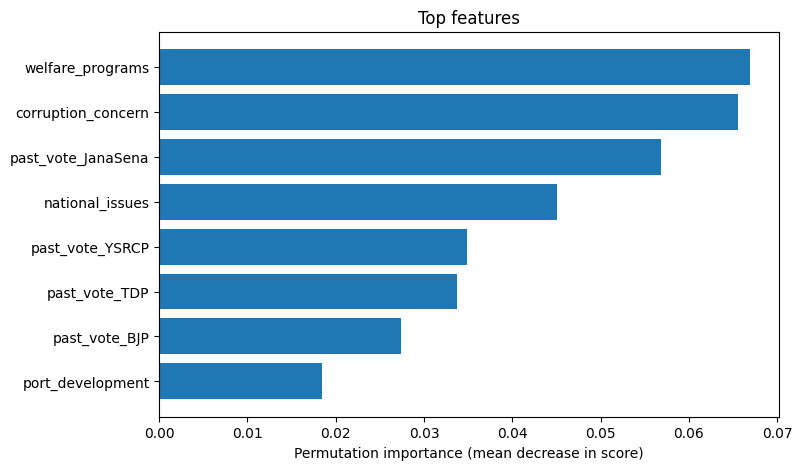

In [ ]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

perm = permutation_importance(best_rf, X_test_enc, y_test, n_repeats=30, random_state=RANDOM_STATE, n_jobs=-1)
imp_df = pd.DataFrame({'feature': X_test_enc.columns, 'importance_mean': perm.importances_mean}).sort_values('importance_mean', ascending=False).reset_index(drop=True)
print("Top 12 features by permutation importance:")
print(imp_df.head(12))

# Plot top 8
top = imp_df.head(8)
plt.figure(figsize=(8,5))
plt.barh(top['feature'][::-1], top['importance_mean'][::-1])
plt.xlabel('Permutation importance (mean decrease in score)')
plt.title('Top features')
plt.show()

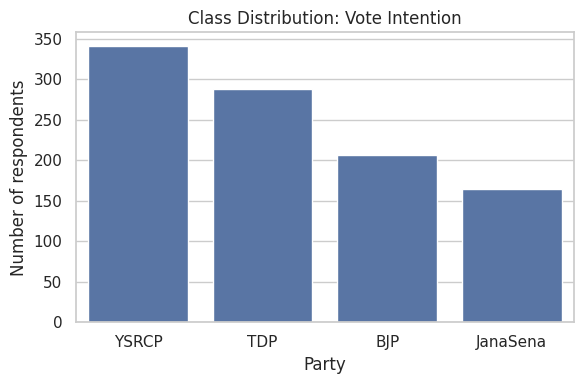

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='vote_intention', order=df['vote_intention'].value_counts().index)
plt.title("Class Distribution: Vote Intention")
plt.xlabel("Party")
plt.ylabel("Number of respondents")
plt.tight_layout()
plt.show()

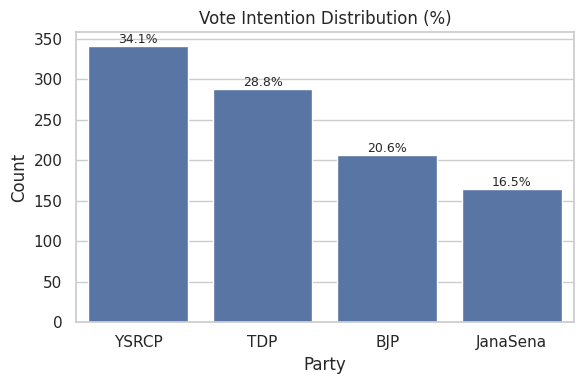

In [ ]:
plt.figure(figsize=(6,4))
order = df['vote_intention'].value_counts().index
ax = sns.countplot(data=df, x='vote_intention', order=order)
plt.title("Vote Intention Distribution (%)")
plt.xlabel("Party")
plt.ylabel("Count")

# Add % labels on top
total = len(df)
for p in ax.patches:
    count = p.get_height()
    pct = 100 * count / total
    ax.annotate(f"{pct:.1f}%", (p.get_x() + p.get_width()/2., count),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

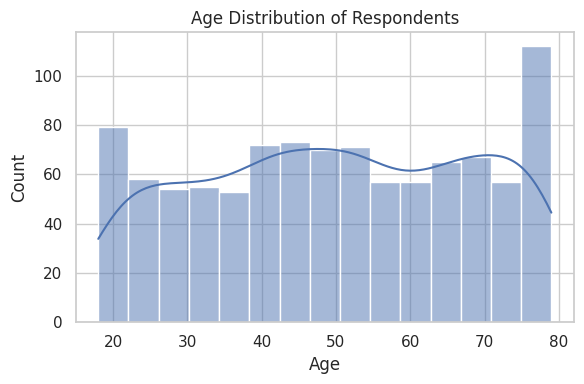

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(df['age'], bins=15, kde=True)
plt.title("Age Distribution of Respondents")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

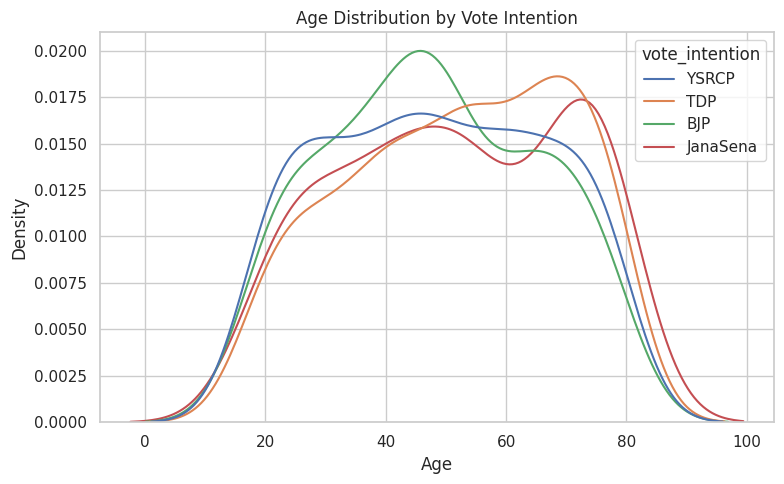

In [ ]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=df, x='age', hue='vote_intention', common_norm=False)
plt.title("Age Distribution by Vote Intention")
plt.xlabel("Age")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

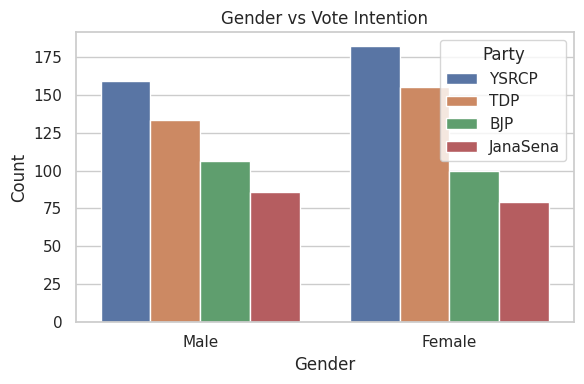

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='gender', hue='vote_intention')
plt.title("Gender vs Vote Intention")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title="Party")
plt.tight_layout()
plt.show()

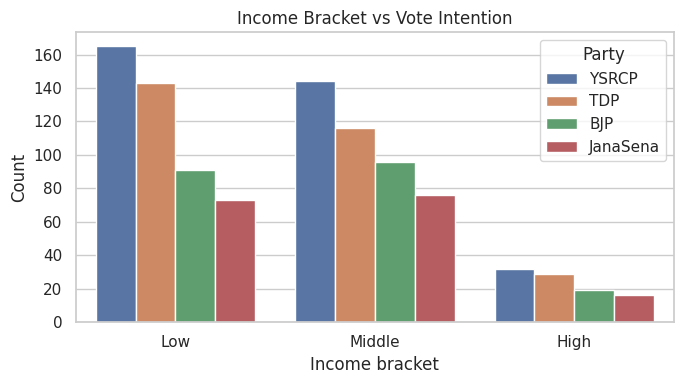

In [ ]:
plt.figure(figsize=(7,4))
sns.countplot(data=df, x='income_bracket', hue='vote_intention')
plt.title("Income Bracket vs Vote Intention")
plt.xlabel("Income bracket")
plt.ylabel("Count")
plt.legend(title="Party")
plt.tight_layout()
plt.show()

In [ ]:
issue_cols = [
    'port_development','infrastructure','welfare_programs','corruption_concern',
    'education_quality','leader_image','national_issues','law_and_order',
    'environment_concern','transport_public','housing_affordability',
    'women_safety','small_business_support'
]

# Compute mean score per party per issue
issue_means = df.groupby('vote_intention')[issue_cols].mean().round(2)
issue_means

,port_development,infrastructure,welfare_programs,corruption_concern,education_quality,leader_image,national_issues,law_and_order,environment_concern,transport_public,housing_affordability,women_safety,small_business_support
vote_intention,,,,,,,,,,,,,
BJP,3.62,3.85,3.18,3.84,3.62,3.59,4.28,4.07,3.08,3.51,3.26,3.60,3.46
JanaSena,3.68,3.55,3.75,3.24,3.42,4.21,3.12,3.19,3.46,3.68,3.40,4.04,3.61
TDP,3.90,4.19,3.43,3.45,3.98,3.83,3.19,3.41,3.61,4.02,3.78,3.67,3.91
YSRCP,4.26,4.00,4.17,2.62,3.77,4.18,2.99,3.26,3.40,3.82,3.46,3.89,3.77


<Figure size 800x500 with 0 Axes>

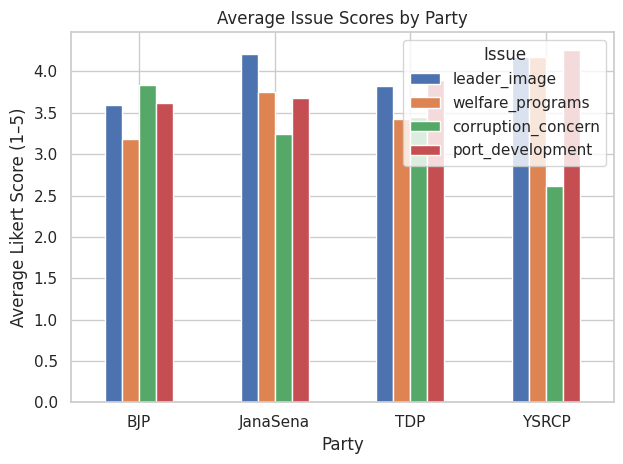

In [ ]:
top_issues = ['leader_image', 'welfare_programs', 'corruption_concern', 'port_development']

plt.figure(figsize=(8,5))
issue_means[top_issues].plot(kind='bar')
plt.title("Average Issue Scores by Party")
plt.ylabel("Average Likert Score (1–5)")
plt.xlabel("Party")
plt.xticks(rotation=0)
plt.legend(title="Issue")
plt.tight_layout()
plt.show()

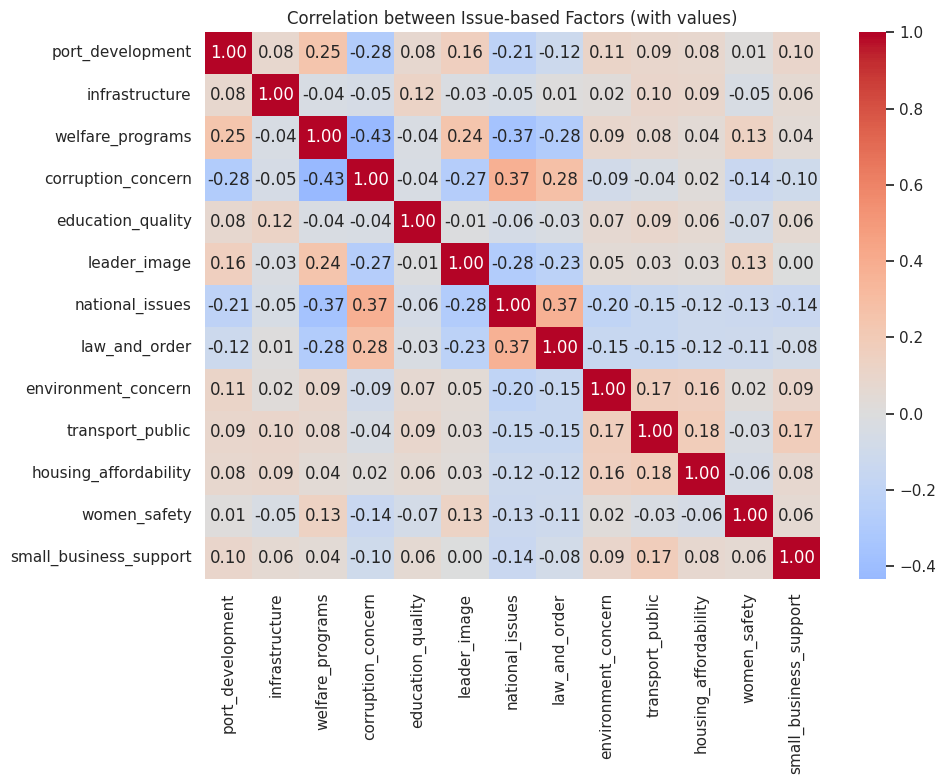

In [ ]:
issue_cols = [
    'port_development','infrastructure','welfare_programs','corruption_concern',
    'education_quality','leader_image','national_issues','law_and_order',
    'environment_concern','transport_public','housing_affordability',
    'women_safety','small_business_support'
]

# Compute correlation matrix only for issue-based numerical features
corr = df[issue_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation between Issue-based Factors (with values)")
plt.tight_layout()
plt.show()

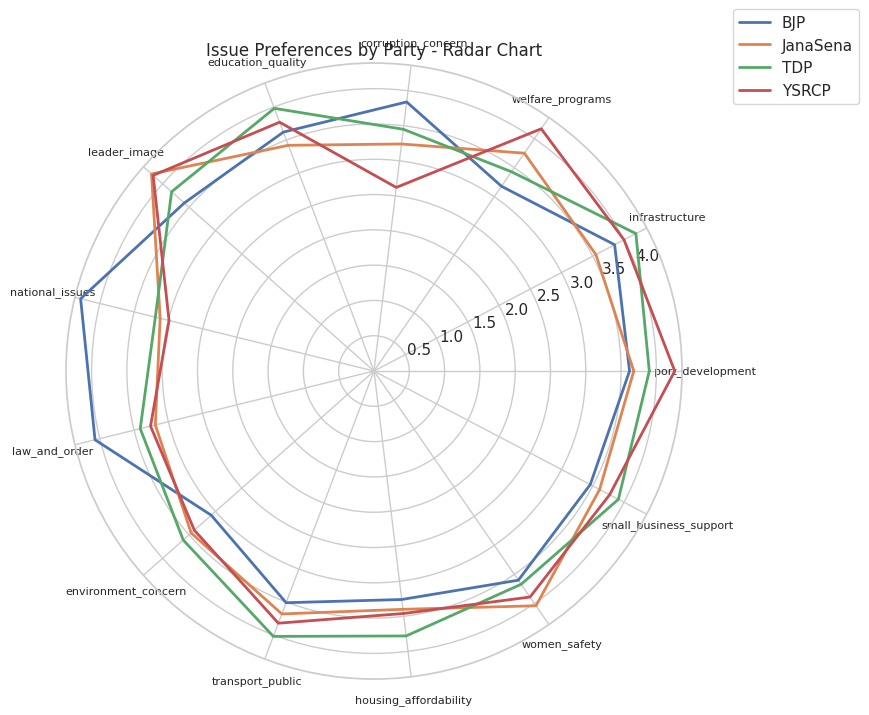

In [ ]:
import matplotlib.pyplot as plt
from math import pi

labels = issue_cols
parties = issue_means.index

plt.figure(figsize=(8,8))

for party in parties:
    values = issue_means.loc[party].values.tolist()
    values += values[:1]
    angles = [n / float(len(labels)) * 2 * pi for n in range(len(labels))]
    angles += angles[:1]

    plt.polar(angles, values, linewidth=2, label=party)

plt.xticks(angles[:-1], labels, fontsize=8, rotation=45)
plt.title("Issue Preferences by Party - Radar Chart")
plt.legend(loc='upper right', bbox_to_anchor=(1.3,1.1))
plt.show()

In [ ]:
y_test_pred = best_rf.predict(X_test_enc)
from sklearn.metrics import precision_score, recall_score

summary_metrics = pd.DataFrame({
    'Accuracy': [accuracy_score(y_test, y_test_pred)],
    'Macro_F1': [f1_score(y_test, y_test_pred, average='macro')],
    'Macro_Precision': [precision_score(y_test, y_test_pred, average='macro')],
    'Macro_Recall': [recall_score(y_test, y_test_pred, average='macro')]
}).round(3)

print("Overall Test Metrics:\n")
print(summary_metrics)

Overall Test Metrics:

   Accuracy  Macro_F1  Macro_Precision  Macro_Recall
0     0.813     0.812            0.833         0.801
